In [1]:
from prody import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import plotly.graph_objects as go
from scipy.interpolate import griddata
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.ndimage import gaussian_filter
from matplotlib import gridspec
from matplotlib.colors import LinearSegmentedColormap, Normalize, to_rgb
import fnmatch
import os

### Importation of PMF Data

#### Data Implementation
X axis will be dihedrals, Y axis is setted as distances and Z axis is energy

In [2]:
path = f'./'

In [3]:

# Load the data function
def load_data(filename):
    return np.loadtxt(filename, skiprows=1)  # Skip the header line

# Function to round distances
def round_to(number):
    return (1.5 * round(number / 1.5)) - 0.5

# Function to prepare the data for contour plot
def prepare_contour_data(dihedrals, distances, dihedral_range, distance_range):
    X, Y = np.meshgrid(dihedral_range, distance_range)
    
    # Initialize the Z array with zeros
    Z = np.zeros((len(distance_range), len(dihedral_range)))
    
    # Round the dihedral and distance values
    rounded_dihedrals = [round(d, -1) for d in dihedrals]
    rounded_distances = [round_to(d) for d in distances]
    
    # Populate the Z array
    for i in range(len(rounded_dihedrals)):
        if rounded_dihedrals[i] in dihedral_range and rounded_distances[i] in distance_range:
            dihedral_idx = list(dihedral_range).index(rounded_dihedrals[i])
            distance_idx = list(distance_range).index(rounded_distances[i])
            Z[distance_idx, dihedral_idx] -= 1
    
    return X, Y, Z

# Function to find files matching a pattern
def find_files(pattern):
    files = []
    for file in os.listdir():
        if fnmatch.fnmatch(file, pattern):
            files.append(file)
    return sorted(files)


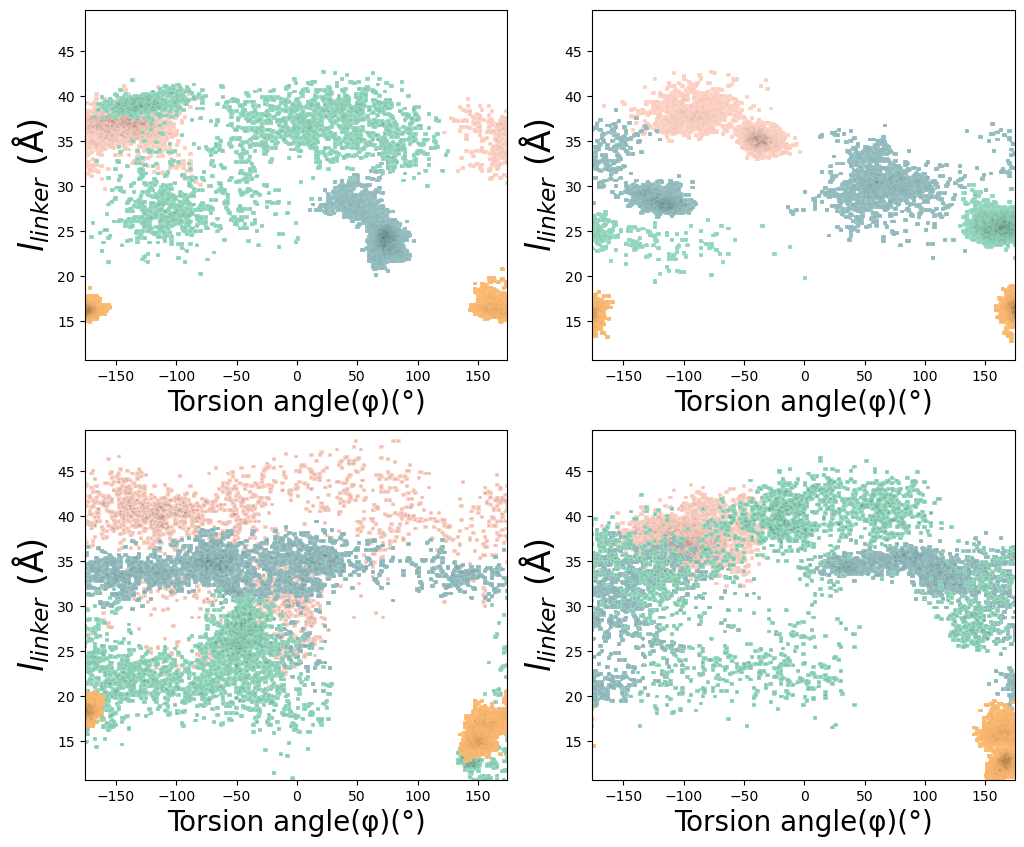

In [4]:
# ---------- helper to build transparent->darker colormap from a hex color ----------
def make_rgba_shadow(hex_color, alpha0=0.0, alpha1=1.0, darken_factor=0.65):
    r, g, b = to_rgb(hex_color)  # 0–1 floats
    dr, dg, db = [max(0.0, c * darken_factor) for c in (r, g, b)]  # darker shade
    # two stops: fully transparent base → darker, fully opaque
    return [(r, g, b, alpha0), (dr, dg, db, alpha1)]

# Function to prepare data for contour plotting using binned data
def prepare_contour_data(dihedrals, distances, dihedral_range, distance_range, bins=10):
    histogram, xedges, yedges = np.histogram2d(dihedrals, distances, bins=[dihedral_range, distance_range])
    X, Y = np.meshgrid(xedges[:-1], yedges[:-1])
    Z = histogram.T

    # Apply Gaussian smoothing to create a more contour-like appearance
    Z_smooth = gaussian_filter(Z, sigma=0.2)

    return X, Y, Z_smooth

# Function for the first plot (transparent overlay)
def plot_first_set(axes):
    # Find all files for each system in the specified order
    systems = ['holo_p', 'holo_l', 'apo_p', 'apo_l']

    # Old colors (same hex values as before):
    # 1: #fcb971
    # 2: #96dac0
    # 3: #ffd3c6
    # 4: #96bfc1
    #
    # NOTE: file indices were remapped as:
    # 1->4, 2->3, 3->1, 4->2
    # So colors must follow the NEW numbering:
    # conformer1 = old 3, conformer2 = old 4, conformer3 = old 2, conformer4 = old 1
    rgba_colors = [
        make_rgba_shadow("#ffd3c6"),  # conformer1  (was 3)
        make_rgba_shadow("#96bfc1"),  # conformer2  (was 4)
        make_rgba_shadow("#96dac0"),  # conformer3  (was 2)
        make_rgba_shadow("#fcb971"),  # conformer4  (was 1)
    ]

    # Create custom colormaps from the two-stop RGBA lists
    custom_colormaps = [
        LinearSegmentedColormap.from_list('conformer1', rgba_colors[0]),
        LinearSegmentedColormap.from_list('conformer2', rgba_colors[1]),
        LinearSegmentedColormap.from_list('conformer3', rgba_colors[2]),
        LinearSegmentedColormap.from_list('conformer4', rgba_colors[3]),
    ]

    # Define the range for dihedral and distance (uses global 'bins')
    dihedral_range = np.linspace(-176, 176, bins)
    distance_range = np.linspace(10.75, 49.75, bins)

    # Prepare data and plot for each system
    for idx, system in enumerate(systems):
        combined_files = [f'dihedral_distance_{system}_{i+1}.txt' for i in range(4)]

        ax = axes[idx]

        for i, combined_file in enumerate(combined_files):
            data = np.loadtxt(combined_file)
            dihedrals = data[:, 0]
            distances = data[:, 1]
            X, Y, Z = prepare_contour_data(dihedrals, distances, dihedral_range, distance_range, bins)

            # Mask minimum bin to avoid a solid block at zero
            min_energy = np.min(Z)
            Z[Z == min_energy] = np.nan

            # Plot the density with custom colormaps and levels
            ax.contourf(X, Y, Z, levels=250, cmap=custom_colormaps[i], alpha=0.9, zorder=0.7)

        # Add labels and title
        ax.set_xlabel('Torsion angle(φ)(°)', fontsize=20)
        ax.set_ylabel(r'$l_{\mathit{linker}}$ (Å)', fontsize=24)

# Create figure and gridspec layout for the combined plot
fig = plt.figure(figsize=(12, 10))
gs = gridspec.GridSpec(2, 2, figure=fig, width_ratios=[1, 1], height_ratios=[1, 1])
gs.update(wspace=0.2, hspace=0.2)

# Create subplots for the smoothed energy contours
axes_contours = [fig.add_subplot(gs[i // 2, i % 2]) for i in range(4)]

bins = 250  # global used inside plot_first_set

# Plot the first set of graphs as an overlay
plot_first_set(axes_contours)

# Show the combined plot
plt.savefig('torsion_dstance_cmd_conf.png', format='png', dpi=1200)
plt.show()
